# Shap variable importance plots

In [1]:
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap

from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

from fatescal.visualize import emulation as emuplt
from fatescal.config import PROJECT_ROOT_PATH

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Define paths and file names
case_name = 'HYY_ST_n128_K4_1D_gpp_et'
file_stem = 'HYY_ST_vcmax85_bbslope80'

result_dir_path = PROJECT_ROOT_PATH / 'data' / 'results'
plot_save_path = result_dir_path / 'plots' / \
    'publication_results' / 'emulator_config'

feature_matrix_path = result_dir_path / 'emulation' / \
    'feature_matrix' / case_name
targets_path = result_dir_path / 'emulation' / \
    'targets' / case_name
emulator_model_path = result_dir_path / 'emulation' / \
    'models' / case_name

In [3]:
# Read data
feature_matrix = pd.read_csv(
    feature_matrix_path / f'{file_stem}.csv', index_col=0
)

targets_y = pd.read_csv(
    targets_path / f'{file_stem}.csv', index_col=0
)

In [4]:
# Load model
emulator_model = joblib.load(
    emulator_model_path / 'gp_regressor.joblib'
)

In [6]:
# Scale y-data
#scaler = StandardScaler()
#scaler.fit(targets_y)
#normalized_y = scaler.transform(targets_y)

# Split train-test data
X_train, X_test, y_train, y_test = train_test_split(
    feature_matrix,
    targets_y,
    train_size=0.8,
    random_state=221,  # b
    shuffle=True,
)

In [7]:
# Make simple evaluation
error_metric_actual = y_test.to_numpy().ravel()
error_metric_predictions = emulator_model.predict(X_test).ravel()

X has feature names, but GaussianProcessRegressor was fitted without feature names


(128, 1)


<Axes: xlabel='Actual negative log-likelihood', ylabel='Predicted negative log-likelihood'>

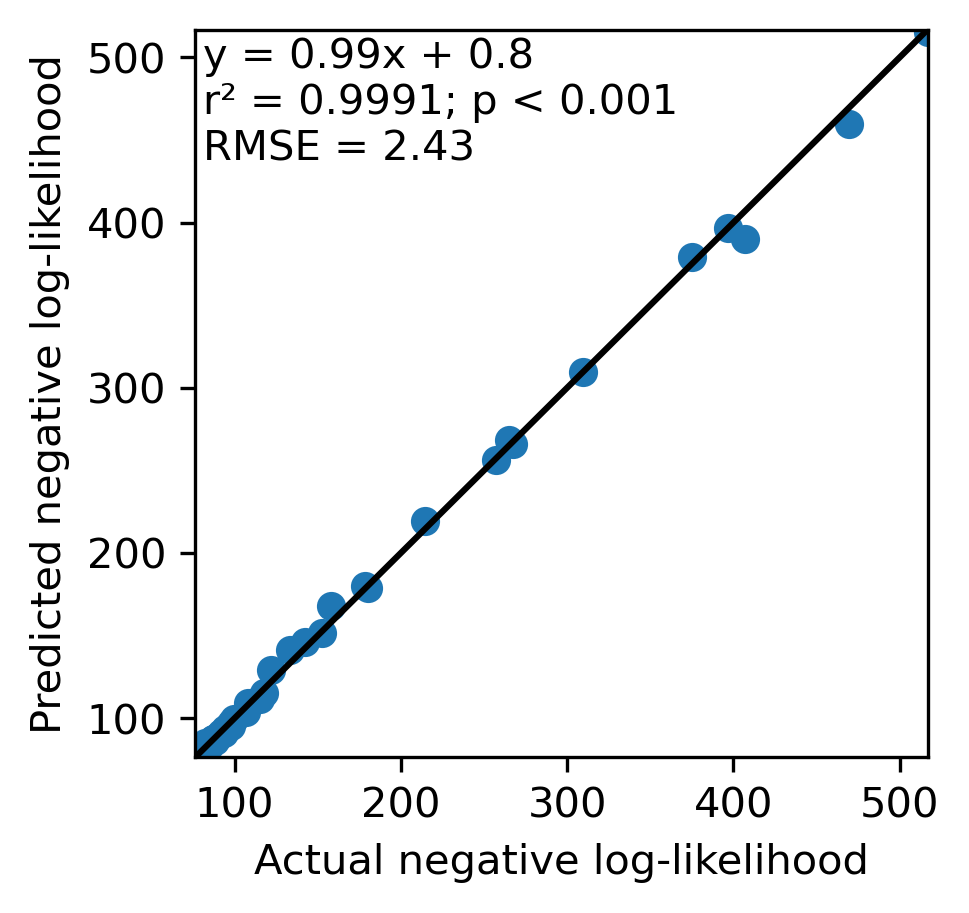

In [9]:
emuplt.plot_emulator_evaluation(
    actual=error_metric_actual,
    predicted=error_metric_predictions,
    metric_code='nll',
    save_fig=False
)

In [11]:
explainer = shap.KernelExplainer(emulator_model.predict, feature_matrix)
shap_values = explainer(feature_matrix)

Using 640 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 640/640 [16:43<00:00,  1.57s/it]


In [16]:
import json
with open(result_dir_path.parent / 'dict' / 'param_names.json', 'r') as param_name_json:
    param_dict = json.load(param_name_json)

In [25]:
shap_values.feature_names = [
    param_dict[x]['pltname'] for x in shap_values.feature_names
]

AttributeError: 'numpy.ndarray' object has no attribute 'items'

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


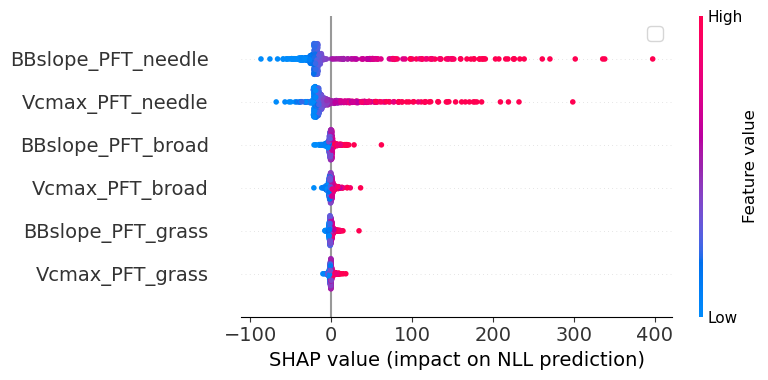

In [32]:
save_fig = True

fig = plt.figure()

SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

shap.plots.beeswarm(shap_values, show=False)

ax = plt.gca()

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=14)

ax.set_xlabel(
    "SHAP value (impact on NLL prediction)"
)

fig.tight_layout()

if save_fig:
    fig.savefig(
        plot_save_path / 'shapley_beeswarm.png',
        dpi=300,
    )

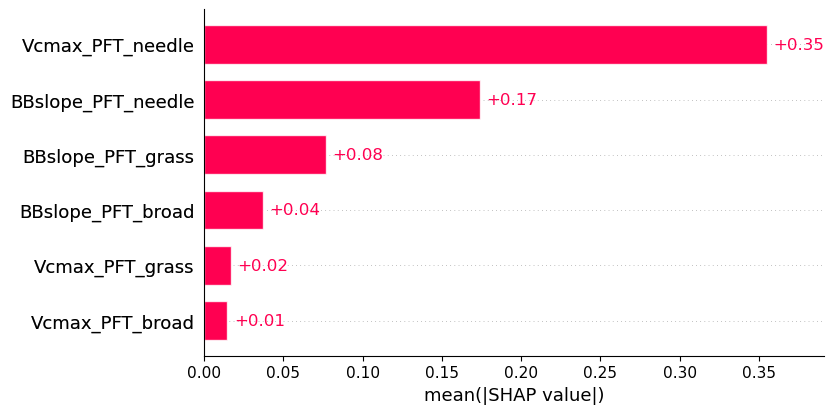

In [11]:
shap.plots.bar(shap_values, show=False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


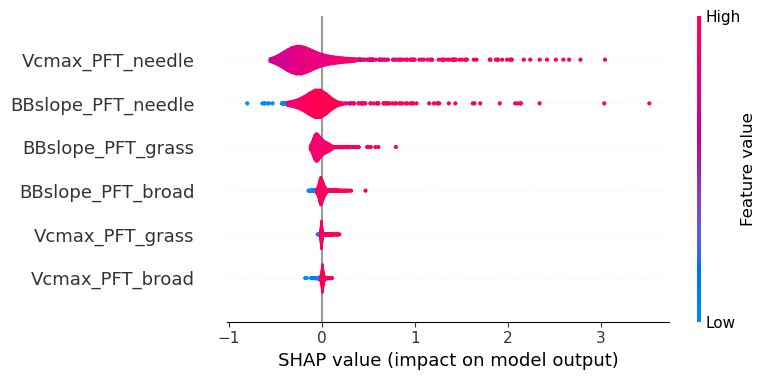

In [15]:
shap.summary_plot(
    shap_values,
    feature_names=shap_values.feature_names,
    plot_type='violin'
)

In [13]:
""" shap.initjs()

shap.force_plot(
    explainer.expected_value,
    shap_values.values,
    X_train.values
) """

' shap.initjs()\n\nshap.force_plot(\n    explainer.expected_value,\n    shap_values.values,\n    X_train.values\n) '

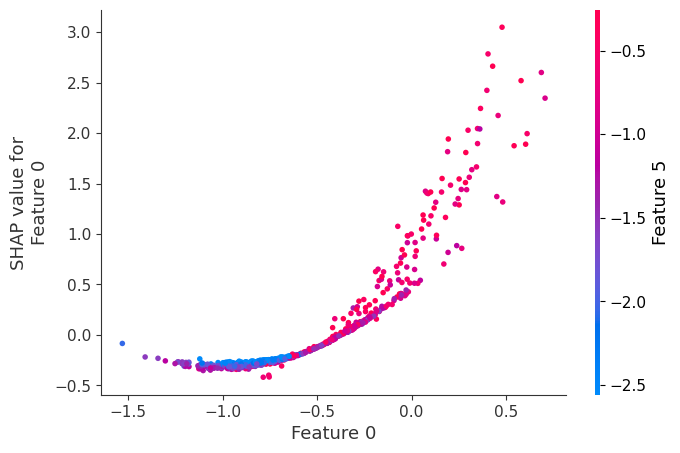

In [14]:
shap.dependence_plot(
    "Feature 0",
    shap_values.values,
    X_train.values
)